# Analyzing the Network of Bots on the Danish Wikipedia
#### Exam project in Computational Social Science 02467
_Nikolaj Topsøe (s214653) and Eliot Claret (s204124)_

Link to [website](https://css-project-02467.github.io/CSS_Project/), and [GitHub repository](https://github.com/CSS-project-02467/CSS_Project).
Nikolaj and Eliot have contributed equally to this project.

## 1. Motivation

For many years now Wikipedia has been one of the most important sources of information on the internet, with millions of articles in all the world's major languages. Relying solely on the collaboration of strangers, Wikipedia has gone from being a radical experiment in free information to a trustworthy source of knowledge. As the project has grown over the years, automation has been vital in keeping articles up to date, making otherwise tedious edits, and empowering contributors to make the most use of the knowledge that they bring. In this project we take a look at the bots that maintain and expand the Danish Wikipedia, how they work together, and see how network- and textual analysis can shed light on their contributions to the site.

First, we load the packages and datasets we've collected.

In [33]:
import nltk
import pywikibot
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
from itertools import chain
from nltk import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from itertools import combinations
from collections import defaultdict
import community as community_louvain

# Ignore warnings for presentation sake (don't try this at home...)
warnings.filterwarnings("ignore")

# Stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('danish')) | set(stopwords.words('english'))

# Load data
pages_dataframe = pd.read_pickle('data/final/pages_dataframe_final.pkl')
bots_dataframe = pd.read_pickle('data/final/bots_dataframe_final')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Basic stats

All the data in this project has been collected by ourselves, using the library 'pywikibot' which provides an easy way to connect to the Wikimedia API. By iterating through all the pages in the Danish Wikipedia, we were able to collect a dataset of roughly 260,000 pages (estimated 85% of all Danish pages), along with all the bots having contributed to those pages, and the categories the pages belong to. All bots on Wikipedia are registered, and by cross-checking the list of bots on the Danish Wikipedia with the contributors to a given page, we could be certain not to get any human users in our dataset.

In addition to the page data, we have also gathered information on all the bots, how many pages they have edited, and the total amount of edits they have performed. In total, we collected data on 197 bots (83% of all the existing active bots). Most of the bots that weren't included in this dataset had no contributions to any pages as of yet, and were therefore deemed not to be of much interest for this experiment. Iterating through all pages is quite time-consuming, since API calls can't be grouped, and various server-side errors meant we had to collect the data in stints. This is the reason why we didn't get a 'complete' dataset, but the collected data is still highly representative for the Danish Wikipedia as a whole.

### Graph construction

From the page data we can construct a graph with the contributing bots constituting the nodes, with links between them if they have contributed to the same page. Each edge will also contain the amount of pages the two bots both have contributed to together.

In [34]:
# Getting edges generated for all pages
edge_dict = defaultdict(lambda: {'pages':[],'n_pages':0})
only_contributor = defaultdict(lambda: 0)
pbar = tqdm(total=pages_dataframe.shape[0])
def page_edges(page):
    pbar.update(1)
    contributors = page['bots']
    if len(contributors) < 2:
        if len(contributors) == 1:
            only_contributor[contributors[0]] += 1
        return []
    contributors.sort()
    contributor_pairs = list(combinations(contributors, r=2))
    for contributor_pair in contributor_pairs:
        edge_dict[contributor_pair]['pages'].append(page['name'])
        edge_dict[contributor_pair]['n_pages'] += 1

# Constructing the graph from the edge dictionary
pages_dataframe.apply(page_edges, axis=1)
G = nx.Graph()
G.add_edges_from(edge_dict.keys())
# Remembering to set the attributes, so that we can use the number of pages in an edge later
nx.set_edge_attributes(G, edge_dict)

100%|█████████▉| 261881/262278 [00:51<00:00, 6608.68it/s] 

In the construction of the graph, we took note of the pages where only one bot have contributed to, and now we can add the number of pages contributed to solely by a given bot to our bot data:

In [35]:
# Add new data to the bots dataframe
only_contributor = pd.DataFrame(list(only_contributor.items()), columns=['name', 'only contributor count'])
bots_dataframe = pd.merge(bots_dataframe, only_contributor, on='name', how='outer').fillna({'only contributor count':0})
bots_dataframe['degree'] = bots_dataframe['name'].apply(lambda name: dict(G.degree)[name])

# Set node attributes
attribute_dict = bots_dataframe.set_index('name').T.to_dict('dict')
nx.set_node_attributes(G, attribute_dict)

We now visualize the graph. Given the highly connected nature of the graph, normal methods with automatic placement of the nodes doesn't work, so we make our own, placing the nodes on an expanding spiral, in order of degree:

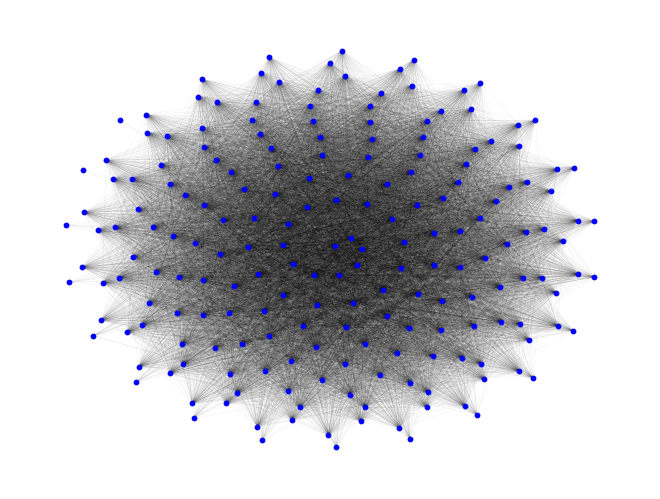

In [36]:
points = np.arange(len(G.nodes))
degree_dict = dict(G.degree)
radians, radii = points ** 0.8, points ** 0.5
coordinates = np.vstack((np.sin(radians), np.cos(radians))).T * np.expand_dims(radii, 1)
sorted_nodes = sorted(degree_dict, key=lambda k: degree_dict[k], reverse=True)
pos = {sorted_nodes[i]: coordinates[i] for i in range(len(sorted_nodes))}
nx.draw(G, node_color='blue', pos=pos,  node_size=10, width=0.02)
plt.savefig('graph_visual', dpi=500)

As we can see, its like one big cotton ball of connections. Let's try to analyze it. 

## 3. Tools, theory and analysis.
_Talk about how you’ve worked with text, including regular expressions, unicode, etc.
Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.
How did you use the tools to understand your dataset?_

Now we get to the actual analysis of the data. To summarize: we first analyze the graph, and take a look at some summary stats: the degree distribution, assortativity, and the closeness centralities of the nodes. We then use the Louvain algorithm to detect communities in the graph, which leads us into the textual analysis. Having extracted a good partition from the graph, we try to make sense of the communities using both the categories of pages in them and the contributions made by the bots. Lastly, guided by the top 10 tokens from the contributions of each bot, we look at a few interesting individuals, to get a sense of the breadth of functions served by the bots.  


### Graph analysis

We first take a look at the summary statistics of the graph:

In [37]:
# Summary statistics of graph
n_nodes = len(G.nodes)
n_edges = len(G.edges)
mean_degree = np.mean(list(dict(G.degree).values()))
n_components = nx.number_connected_components(G)
print(f'Number of nodes in graph: {n_nodes}')
print(f'Number of edges in graph: {n_edges} out of {n_nodes*(n_nodes-1)/2} possible')
print(f'Mean degree <k> in graph: {mean_degree}')
print(f'Number of connected components in graph: {n_components}')

Number of nodes in graph: 197
Number of edges in graph: 15024 out of 19306.0 possible
Mean degree <k> in graph: 152.5279187817259
Number of connected components in graph: 1


From the basic stats, we see that the network is extremely connected, since approximately 75% of the possible existing edges actually are there. We see that the average degree, 152, is not that far off from the total number of nodes, suggesting that many of the bots have contributed to a page with almost every other bot at some point in time. The mean degree is way past log(N), and the graph is therefore in the 'connected' regime, as according to Barabasi [1].

We now take a look at the degree distribution, as contrasted with a random graph

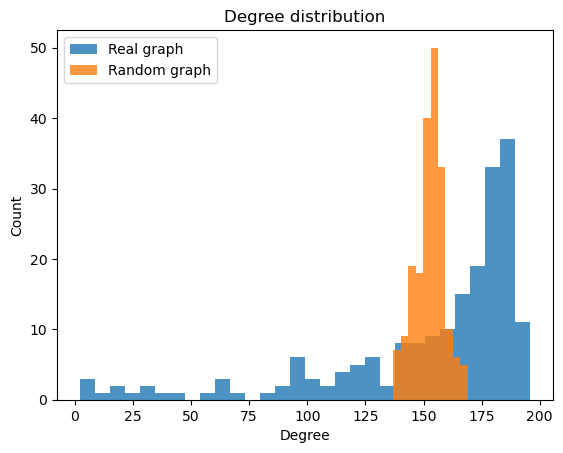

In [38]:
# Generating a random graph to compare with
p = 2*n_edges/(n_nodes*(n_nodes-1))
G_random = nx.gnp_random_graph(n_nodes, p)
g_deg_random = dict(G_random.degree).values()

# Plotting
g_deg = dict(G.degree).values()
plt.hist(g_deg, alpha=0.8,bins=30, label='Real graph')
plt.hist(g_deg_random, alpha=0.8, label='Random graph')
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.legend()
plt.savefig('degree_distribution', dpi=300)
plt.show()

We see that, like many other graphs in the real world the degree distribution is far more heavy-tailed than for the random graph. Interestingly, there are many more heavily connected nodes than sparsely connected ones, that is, the distribution shows a heavy right-skew. This is in contrast with many real-world networks where most nodes have quite low degree, and only a few nodes have very high degree.

We now take a look at the distribution of page edit counts for each bot, shown on a log scale, since the edit counts have a large span from 1 to ~200,000. 

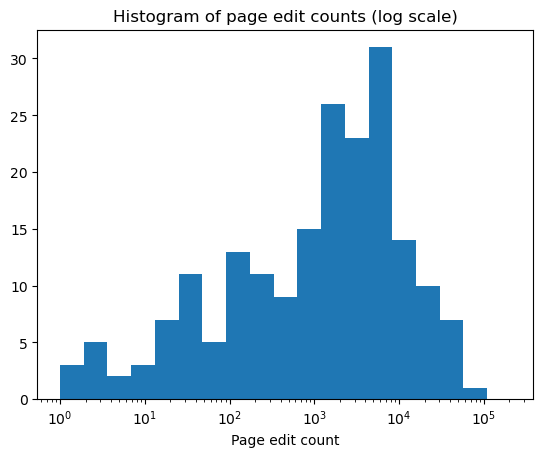

In [39]:
counts = bots_dataframe['count']
plt.hist(bots_dataframe['count'], bins=np.logspace(np.log10(min(counts)), np.log10(max(counts)), 20))
plt.xscale('log')
plt.title('Histogram of page edit counts (log scale)')
plt.xlabel('Page edit count')
plt.savefig('edit_distribution', dpi=300)

Remembering that the x-axis is on a log scale we see a very left-skewed distribution - in contrast to the right-skewed degree distribution - meaning that most bots have made a low to moderate amount of edits. This is quite interesting, now we take a closer look at the relationship between the degree of a node and the different contribution metrics.

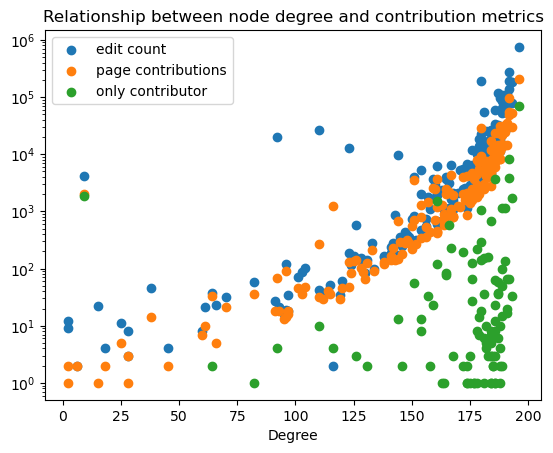

In [40]:
plt.scatter(bots_dataframe['degree'], bots_dataframe['edit_count'], label='edit count')
plt.scatter(bots_dataframe['degree'], bots_dataframe['count'], label='page contributions')
plt.scatter(bots_dataframe['degree'], bots_dataframe['only contributor count'], label='only contributor')
plt.yscale('log')
plt.title('Relationship between node degree and contribution metrics')
plt.xlabel('Degree')
plt.legend()
plt.savefig('edit_over_degree', dpi=300)

We see that there is a clear power-law relationship between the degree and the amount of contributions of all types. We thus see that the more bots a given bot has collaborated with, the higher that bots edit count is likely to be, and the effect is more pronounced the higher the degree.
 
The fact that many bots have high degree, but most bots only have a low to moderate amount of edits logically means that there must be a few pages that a significant fraction of all bots have contributed to. Otherwise the striking combination of a right-skew degree distribution and a left-skew edit contribution would not be possible. We take a look to find out if this is indeed the case:

In [41]:
# Getting the top pages by number of contributors, and seeing how many unique bots are 
# among their contributors
unique_bots = set()
top_10_by_n_contribs = pages_dataframe.sort_values(by='n_contributors', ascending=False).head(10)
top_10_by_n_contribs['bots'].head(5).apply(lambda bots: [unique_bots.add(bot) for bot in bots])
print(f'Bots having contributed to top 5 pages: {len(unique_bots)} out of {len(bots_dataframe)}')
top_10_by_n_contribs[['name', 'n_contributors']]

Bots having contributed to top 5 pages: 102 out of 197


,name,n_contributors
36251,Hviderusland,66
157722,Schweiz,66
71376,Kroatien,66
179622,Afghanistan,65
43565,Israel,65
61788,Kasakhstan,64
70954,Kristendom,64
4306,Frankrig,63
2408,Forenede Nationer,63
106515,Muhammed,63


We see that there indeed some pages that a third of all bots have contributed to. In addition, we see that the set of contributors to the top 5 pages includes over half of all the bots. This explains how most bots have collaborated with most other bots even though most bots only have contributed to a few pages; a few important pages have made collaborators of the majority of the bots, regardless of edit counts. It comes as no surprise that these pages are on topics of global significance.

Now we look at the assortativities of the graph. The assortativity is a way to measure to what degree nodes with similar attributes tend to be linked. A negative score for a given attribute shows a tendency for nodes to be linked with other nodes different from themselves, and vice versa with a positive score.

In [42]:
g_deg_assort = nx.degree_assortativity_coefficient(G)
g_count_assort = nx.attribute_assortativity_coefficient(G, 'count')
g_edit_count_assort = nx.attribute_assortativity_coefficient(G, 'edit_count')
g_only_contrib_assort = nx.attribute_assortativity_coefficient(G, 'only contributor count')

print(f'Assortativity by degree: {g_deg_assort}')
print(f'Assortativity by page count: {g_count_assort}')
print(f'Assortativity by edit count: {g_edit_count_assort}')
print(f'Assortativity by only contributor pages: {g_only_contrib_assort}')

Assortativity by degree: -0.23707266331244956
Assortativity by page count: -0.005738042216992627
Assortativity by edit count: -0.0055661349891391
Assortativity by only contributor pages: -0.023442735883572745


Since the network has too many edges to allow us to feasible compare it to random graphs using the configuration model (with 150,000 edges, each time takes upwards of 6 hours), it is a bit difficult to conclude anything definitively, however, the assortativity by degree and only contributor pages looks like they could be significantly different from random. This would suggest that bots do not tend to collaborate mostly with bots of similar degree, which makes sense in a highly connected network, where most nodes are connected to most other nodes. It would also seem to make sense, unsurprisingly, that bots contributing to many pages as the only bot don't tend to collaborate with other bots that do the same.

Now we look at the closeness centrality. The closeness centrality is a way to express the distance from one node to the other nodes in the network. The scores run from 0 to 1, the higher the score the shorter the average path from the node to the other nodes.

In [43]:
# Get closeness centrality using nx built-in function.
c_centrality = nx.closeness_centrality(G)
c_centrality_sorted = dict(sorted(c_centrality.items(), key=lambda item: item[1]))
top5_c = list(c_centrality_sorted.items())[:-6:-1]

# Print mean and top 5 closeness centralities
print(f'Mean centrality: {np.mean(list(c_centrality.values()))}\n')
for name, centrality in top5_c:
    print(f'Name: {name}, centrality: {centrality}')

Mean centrality: 0.8412248604265667

Name: Steenthbot, centrality: 1.0
Name: Thijs!bot, centrality: 0.9849246231155779
Name: EmausBot, centrality: 0.9849246231155779
Name: Xqbot, centrality: 0.98
Name: MGA73bot, centrality: 0.98


Unsurprisingly - given the highly connected network - we see that the closeness centrality for the top 5 nodes are very high, with the highest actually being 1.0. This is because it is actually connected to all other nodes, which means all bots have collaborated on a page with this bot. We found that this bot, 'Steenthbot', is actually being used to supervise the status of other bots, and edits their pages when their bot status is changed. This explains why it has interacted with all the other bots.

We now try to partition the graph and use some textual analysis to get further insights on the network. We now use the Louvain algorithm to attempt to separate the graph into communities for analysis. The Louvain algorithm works by a heuristic, greedy optimization of the modality of different partitions (the modality is a score expressing the density of links within as opposed to outside of the communities defined by a given partition, the higher the 'better'). It should thus give us a sensible partition to work with.

In [44]:
# get most likely partition
partition = community_louvain.best_partition(G, weight='n_pages')
def communities_of_page(bots):
    communities = []
    for bot in bots:
        try:
            communities.append(partition[bot])
        except KeyError:
            pass
    return list(set(communities))

n_communities = max(partition.values()) + 1
bots_dataframe['community'] = bots_dataframe['name'].apply(lambda name: partition[name])
pages_dataframe['communities'] = pages_dataframe['bots'].apply(communities_of_page)
n_bots_0 = sum(np.array(list(partition.values()))==0)
n_bots_1 = sum(np.array(list(partition.values()))==1)
print(f'Number of communities: {n_communities}')
print(f'Size of community 0: {n_bots_0}')
print(f'Size of community 1: {n_bots_1}')

Number of communities: 2
Size of community 0: 125
Size of community 1: 72


We see that the algorithm detects only two communities, with 118 and 79 nodes in each (if you rerun the code you might get slightly different results). This hardly surprising, given the highly connected nature of the network. However, this also means that there is little hope that we can gain much information by analyzing these two communities, but we will try it out. We first use the visualization from above to show the graph with the nodes marked by community:


100%|██████████| 262278/262278 [01:09<00:00, 6608.68it/s]

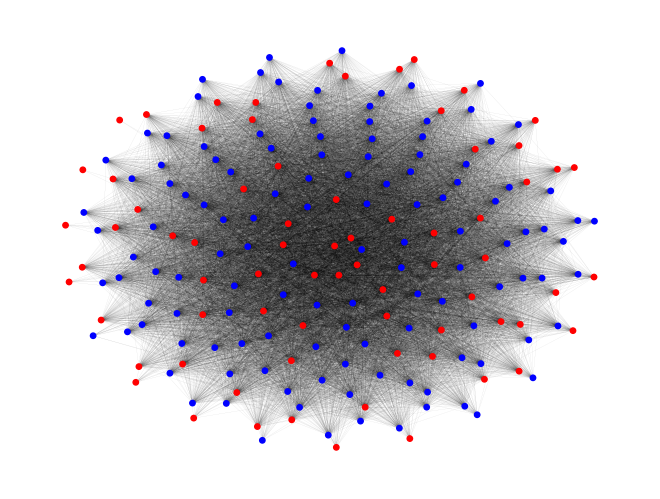

In [45]:
color_code = {0: 'blue', 1: 'red'}
colors = [color_code[partition[node]] for node in G.nodes]
nx.draw(G, node_color=colors, pos=pos,  node_size=15, width=0.02)
plt.savefig('graph_visual_community', dpi=500)

This is still a bit difficult to decipher, so we look at relative degree distributions for the two communities:

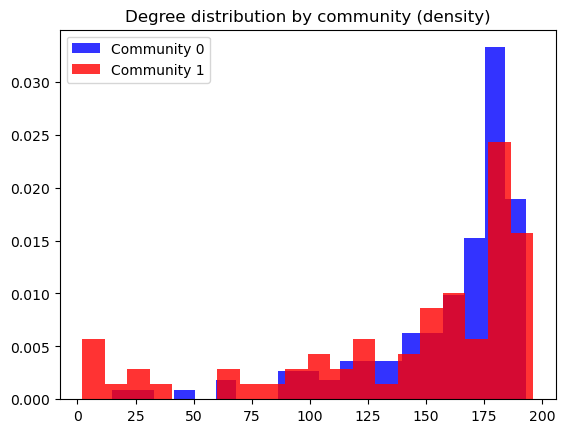

In [46]:
degree_0 = [degree_dict[node] for node in G.nodes if partition[node] == 0]
degree_1 = [degree_dict[node] for node in G.nodes if partition[node] == 1]
plt.hist(degree_0, color='blue',bins=20, alpha=0.8, density=True, label='Community 0')
plt.hist(degree_1, color='red',bins=20, alpha=0.8, density=True, label='Community 1')
plt.legend()
plt.title('Degree distribution by community (density)')
plt.savefig('degree_community', dpi=300)

Here we see something interesting. It looks like the degree distribution of community 1 is less skewed to the right, and has a lot more nodes with very low degree. We now turn to the content of the edits to gather more information

We start by tokenizing the lists of categories each page belongs to, after which we create the corpus for pages belonging to each community. In order to keep the tokens informative we filter out stop words, and a few words found in preliminary analysis to be too common to be informative (in this case 'wikipedia' and 'wikidata'). We also exclude special characters, though not, importantly, non-latin characters, since som of the edits contain characters from other alphabets.

In [47]:
# Function to tokenize category lists.
def tokenize_category_list(category_list, exclude_stop=True):
    # Adding stop words based on observations of superflous terms
    stop_words_category = stop_words | {'wikipedia','wikidata'}
    text = ' '.join(category_list)
    text = text.lower()
    # Filtering out numbers and other characters
    text = ''.join([char for char in text if (char.isalpha() or char in ' -')])
    tokens = word_tokenize(text)
    # Exclude stop words
    if exclude_stop:
        return [token for token in tokens if not token in stop_words_category]
    return tokens

pages_dataframe['tokens'] = pages_dataframe['categories'].apply(tokenize_category_list)
# Generating the corpus based on communities
corpus = pages_dataframe[['communities','tokens']].explode('communities').groupby('communities')['tokens'].apply(lambda x: list(chain(*x)))

We now define the functions needed to perform TF-IDF analysis on the tokens. TF-IDF allows us to find informative tokens by finding frequent terms and weighing them by the information content of the term across the corpus. This is a good way to find not only common words, but _informatively_ common words.

In [48]:
# Returns top k terms as defined by TF-IDF
def top_k_terms_TF_IDF(tokens, k, IDF_dict):
    tokens, counts = np.unique(tokens, return_counts=True)
    tfidf = np.zeros(len(counts))
    for i, (token, count) in enumerate(list(zip(tokens, counts))):
        tfidf[i] = count * IDF_dict[token]
    top_k_idxs = np.argsort(tfidf)[:-(k+1):-1]
    return tokens[top_k_idxs]

# Returns top k most frequent terms.
def top_k_terms_TF(tokens, k):
    unique_tokens, counts = np.unique(tokens, return_counts=True)
    top_k_idxs = np.argsort(counts)[:-(k+1):-1]
    return np.array(unique_tokens)[top_k_idxs]

# For the whole corpus define the IDF value for each term and return
# the results as a dictionary: {term:IDF}
def IDF(corpus):
    IDF_dict = defaultdict(lambda: 0)
    N = len(corpus)
    for doc in corpus:
        for term in list(set(doc)):
            IDF_dict[term] += 1
    return {term: np.log(N / count) for term, count in IDF_dict.items()}

In [49]:
IDF_dict = IDF(corpus)
TFIDF_df = pd.DataFrame(data={c: top_k_terms_TF_IDF(corpus[c], 10, IDF_dict) for c in range(2)})
TFIDF_df

,0,1
0,chipset,handlingsreferat
1,garagerockalbum,eksperimentalfilm
2,nonfoodbutikker,filmskolefilm
3,danielle,portrætfilm
4,dna-virus,længde-
5,kalmus-ordenen,breddegrader
6,manier,oplysningsfilm
7,dobbeltstrenget,virksomhedsfilm
8,steel-romaner,rundata-signum
9,ambient-grupper,wfc


We see that this data is a bit difficult to get any meaningful information out of. It would seem like the second community has made a lot of edits on films, although this can also be due to a few very active bots. The top 10 tokens of the second community shows no real pattern. Instead of looking at the pages for the different communities, we can try taking a look at the bots themselves, and the text in their contributions.

We first tokenize the contributions (here we again define additional stop words, that were seen to be uninformatively common):

In [50]:
def tokenize_contributions(contributions, exclude_stop=True):
    # Adding superflous/uninformatively common words to stop words set.
    stop_words_contributions = stop_words | {'robot','r','tilføjer','ændrer','fjerner', 'enwpawbawb'}
    text = ' '.join(contributions)
    text = text.lower()
    # Filter out numbers and symbols
    text = ''.join([char for char in text if (char.isalpha() or char in ' -')])
    tokens = word_tokenize(text)
    # Exclude stop words.
    if exclude_stop:
        return [token for token in tokens if not token in stop_words_contributions]
    return tokens

We calculate the 10 most frequent tokens for each bot, and collect the corpus for each community. By doing this we give very active bots and bots with lower activity equal weight, so we can analyze their function without having to take volume into consideration.

In [51]:
pbar = tqdm(total=bots_dataframe.shape[0])
def top_k_tokens(bot_name, k=10):
    pbar.update(1)
    site = pywikibot.Site('da', 'wikipedia')
    bot = pywikibot.User(site, bot_name)
    contributions = list(bot.contributions())
    contributions_text = [c[-1] for c in contributions]
    tokens = tokenize_contributions(contributions_text)
    return top_k_terms_TF(tokens, k)

bots_dataframe['top 10 tokens'] = bots_dataframe['name'].apply(top_k_tokens)
corpus = bots_dataframe.groupby('community')['top 10 tokens'].apply(lambda x: list(chain(*x)))


100%|██████████| 262278/262278 [02:57<00:00, 1476.46it/s]

100%|██████████| 197/197 [01:49<00:00,  4.19it/s]

We now look at the TF-IDF terms:

In [52]:
IDF_dict = IDF(corpus)
TFIDF_df = pd.DataFrame(data={c: top_k_terms_TF_IDF(corpus[c], 10, IDF_dict) for c in range(2)})
TFIDF_df

,0,1
0,ar,brug
1,ga,ved
2,rue,nyt
3,kkсанат,dq
4,lt,top
5,sq,اهل
6,br,ابهامزدایی
7,ml,fix
8,жыл,kilde
9,artikel,migrerer


Here we see a clearer pattern. It looks like the first community has many bots maintaining the interlinking structure of the Danish wikipedia to wikis in other languages (ar, ga, lt, ml and br are language codes for Arabic, Irish, Lithuanian, Malaysian, and Breton), whereas the second community shows more activity related to updating other types of data for the pages. Otherwise there is not that much to go on, and further down we discuss what - if given more time - could have been tried to get more information out of the partition.

Looking at the top 10 tokens for the bots, we identified a few of them, that exhibit the breadth of functions served by the bots.

In [53]:
# Define function to get contributions from API based on username
def get_user_contributions(username):
    site = pywikibot.Site('da', 'wikipedia')
    user = pywikibot.User(site, username)
    contributions = user.contributions(total=5)
    return [contrib[3] for contrib in list(contributions)]

# Get and display data from the chosen example bots
example_bots = ['Steenthbot', 'NivlekDaBot', 'DanKoehlBot', 'Rubinbot']
for bot_name in example_bots:
    print(f'Name of bot: {bot_name}\n', '-'*20)
    bot_data = bots_dataframe[bots_dataframe['name'] == bot_name]
    count, edit_count, community, top_10, degree = bot_data['count'], bot_data['edit_count'], bot_data['community'], bot_data['top 10 tokens'], bot_data['degree']
    print(f'Contributions count: {count}, edit count: {edit_count}, community: {community}, degree: {degree}\n')
    print(f'Top 10 tokens: {list(top_10)[0]} \n')
    last_five = get_user_contributions(bot_name)[:5]
    print('Last five edits: \n','\n   '.join(last_five), '\n')
    

Name of bot: Steenthbot
 --------------------
Contributions count: 0    209306
Name: count, dtype: int64, edit count: 0    751959
Name: edit_count, dtype: int64, community: 0    1
Name: community, dtype: int64, degree: 0    196
Name: degree, dtype: int64

Top 10 tokens: ['york' 'new' '-' 'robotassisteret' 'flertydig' 'links' 'ændrede' 'city'
 'kosmetiske' 'ændringer'] 
Last five edits: 
 opdatering med nyeste data *** erstatter eksisterende tekst ***
   opdatering med nyeste data *** erstatter eksisterende tekst ***
   opdatering med nyeste data *** erstatter eksisterende tekst ***
   opdatering med nyeste data *** erstatter eksisterende tekst ***
   opdatering med nyeste data *** erstatter eksisterende tekst *** 

Name of bot: NivlekDaBot
 --------------------
Contributions count: 73    3490
Name: count, dtype: int64, edit count: 73    4053
Name: edit_count, dtype: int64, community: 73    1
Name: community, dtype: int64, degree: 73    151
Name: degree, dtype: int64

Top 10 tokens: ['i

Here we see some of the different functions that bots serve on the Danish wikipedia:

'Rubinbot' is clearly mostly occupied with maintaining interoperability between the Danish Wikipedia and other language wikipedias, by linking similar/identical pages in the two languages.
 
'Steenthbot' is the most active bot on the whole Danish wikipedia with contributions to over 200,000 pages, and from the top 10 tokens we see that most of its work has to do with updating backend data, and 'cosmetic' changes.

 'NivlekDaBot' seems to be engaged in editing data on sports pages, notably on handball and football.
 
 Lastly, 'DanKoehlBot' only has five edits in total, all of them about correcting a common Danish spelling mistake of 'idag' instead of 'i dag', meaning 'yesterday'.
 
We see that the first three bots are all quite highly connected with degrees over 100, despite two of them having fairly moderate edit counts. The last bot 'DanKoehlBot' only has 5 edits, but still a degree of 25. From these examples we get a sense of the variety of contributions by bots on the Danish wikipedia, and see clearly that it would be unrealistic to expect humans to make these fairly tedious edits, especially if relying on volunteers, as is the case for Wikipedia. 
 

### Summarization of findings

 We see that the network of bots is highly connected, meaning that most bots have collaborated with most other bots at some point in time, which is also reflected by the very high mean closeness centrality of 0.84. The degree distribution is skewed to the right, with many highly connected bots, whereas the edit count distribution is skewed to the right, with most bots having a low to moderate amount of edits. We saw that this caused by a few pages, that many, many bots contribute to - pages of high importance like those on countries, religions, and global organizations. This leads to a community that is challenging to partition neatly, even though some tendencies can be seen where some bots are more focused on providing cross-references to wikis of other languages.
  
From our textual analysis we were able to gain insights into the various functions served by the bots ranging from fixing typos, to updating the way information is presented on sports pages, linking the Danish wikipedia to the Persian wiki, to meta-data on bot activity. In making these tedious but important edits, the bots are clearly essential in ensuring that Wikipedia remain one of the top go-to places for information on the internet.

## 4. Discussion

In collecting the dataset we succesfully created a quite large dataset, which enabled us to get a comprehensive picture of the way bots contribute to the wiki. Through our network analysis we saw how the network of collaborating bots was very highly connected. The fact that the degree distribution is so heavily right-skewed is quite interesting, and in contrast to many human networks, were most people are not especially connected, except for a few highly connected individuals - like the network of collaborating scientists analyzed earlier in the course. It would be interesting to further investigate under which circumstances networks tend to have right- or left-skewed degree distributions.

In this project we had expected the analysis of the communities and their most frequent terms to be more informative than they were. The reason that wasn't the case was firstly the highly connected nature of the network, which led to Louvain algorithm having difficulties in neatly separating the network into communities. We saw that one community seemed to be more engaged in linguistic interoperability, but other than that, there was not that much more to go on. It may be that wikipedia bots can for the most part not be separated into different communities, and are better thought of as a large clique. In addition, due to the sparse and specialized nature of the contributions text, making the tokens a bit difficult to parse in a consistent way, although we were still able to gain some insights into the contributions of different bots.


If we were to improve on the analysis we would probably try to find some more ways to use textual analysis to shed light on the activities of the different bots. One way could be to somehow define some categorizations for the different edits, and compare the frequencies with which the different categories appear across communities. We could also try to draw text from the pages themselves. The reason we did not do this is that most of the edits performed by the bots seemed not so much to relate to the content of the pages themselves, but rather the meta-data and structure of the pages, which arguably our analysis confirmed. Still, there might be insights to draw in choosing to focus more on the content of the pages.